## Reconstructing images from few pixels

In [2]:
!pip install PyWavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB 1.3 MB/s eta 0:00:04
   --- ------------------------------------ 0.3/4.2 MB 4.2 MB/s eta 0:00:01
   ------- -------------------------------- 0.8/4.2 MB 7.0 MB/s eta 0:00:01
   -------- ------------------------------- 0.9/4.2 MB 6.0 MB/s eta 0:00:01
   ---------- ----------------------------- 1.1/4.2 MB 5.4 MB/s eta 0:00:01
   ------------ --------------------------- 1.3/4.2 MB 5.2 MB/s eta 0:00:01
   -------------- ------------------------- 1.5/4.2 MB 5.0 MB/s eta 0:00:01
   --------------- ------------------------ 1.7/4.2 MB 4.8 MB/s eta 0:00:01
   ----------------- ---------------------- 1.8/4.2 MB 4.7 MB/s eta 0:00:01
   ------------------- -------------------- 2.0/4.2 MB 4.6 MB/s eta 0:00:01
   -------------------- ------------------- 2.2/4.2 MB 4.5 MB/s eta 0:00:01
   ---------------------- ----------------- 2.4/4.2 MB 4.5 MB/s eta 0:00:01
   ----------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import glob
import numpy as np
import imageio.v2 as imageio
import pywt

### ---------- Set image folder -------------------
folder = r"E:\CS_image_recovery_demo\pics\\"

if not os.path.exists(folder):
    print(f"Error: Folder '{folder}' does not exist!")
    exit()

list_camera_pics = glob.glob(os.path.join(folder, "*.jpg"))

if not list_camera_pics:
    print("Error: No JPG images found in the folder!")
    exit()

list_camera_pics = sorted(list_camera_pics, key=os.path.getctime) 
pic_file = list_camera_pics[-1]  # Latest image
print(f"Using image: {pic_file}")

### ---- OR choose picture manually ----
pic_file = r"E:\CS_image_recovery_demo\pics\marie_curie.jpg"

# Read image in grayscale
Xorig = imageio.imread(pic_file)
Xorig = Xorig.mean(axis=2)  # Convert to grayscale

# Apply Wavelet Transform
x = pywt.wavedec2(Xorig, wavelet='db1', level=1)
Xorig = pywt.waverec2(x, wavelet='db1')

# Picture size
shape = Xorig.shape
n = np.prod(shape)

# Choose wavelet transform parameters
wlet = 'db12'
L = 3 
amp = np.linspace(1, .2, L)
amp = np.kron(amp, np.ones(3))
amp = np.insert(amp, 0, 20)  # Prepend for approximation coefficient

print("Image processing complete!")


Using image: E:\CS_image_recovery_demo\pics\marie_curie_rec.jpg
Image processing complete!


### A compression test 

Relative compression error: 0.048052840853186334
Original image:


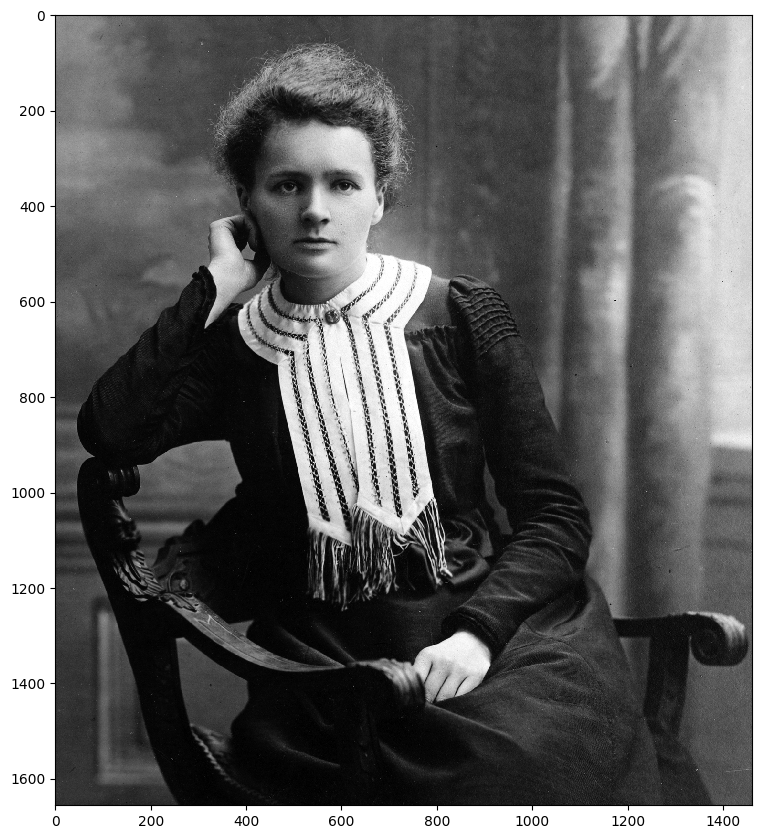

Compressed image (down to 121053 coefficients out of 2421072):


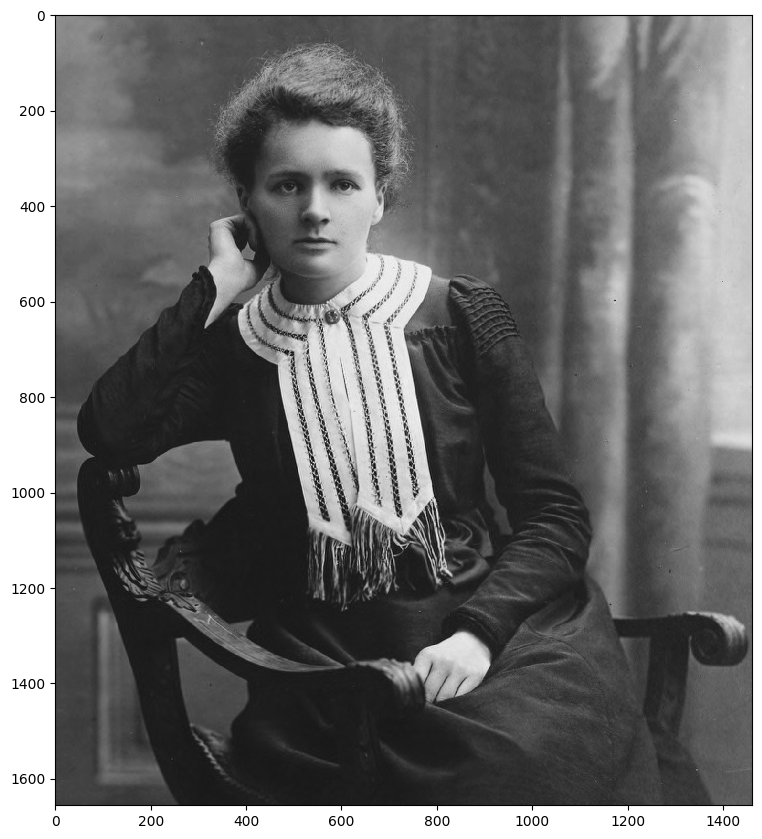

In [7]:
## (not necessary for the rest)
# choose basis for compression              
T = WT(shape, wavelet=wlet,level=L, amplify=amp)

# hard TO
s = int( np.prod(shape)/20 )
TO = hardTO(s)

# compression test
cXorig = compress(T,TO,Xorig)

print("Original image:")
pltPic(Xorig)

print("Compressed image (down to {} coefficients out of {}):".format(s,n) )
pltPic(cXorig)

### Set number of pixels to keep

Total number of pixels: 2421k
Number of remaining pixels: 121k


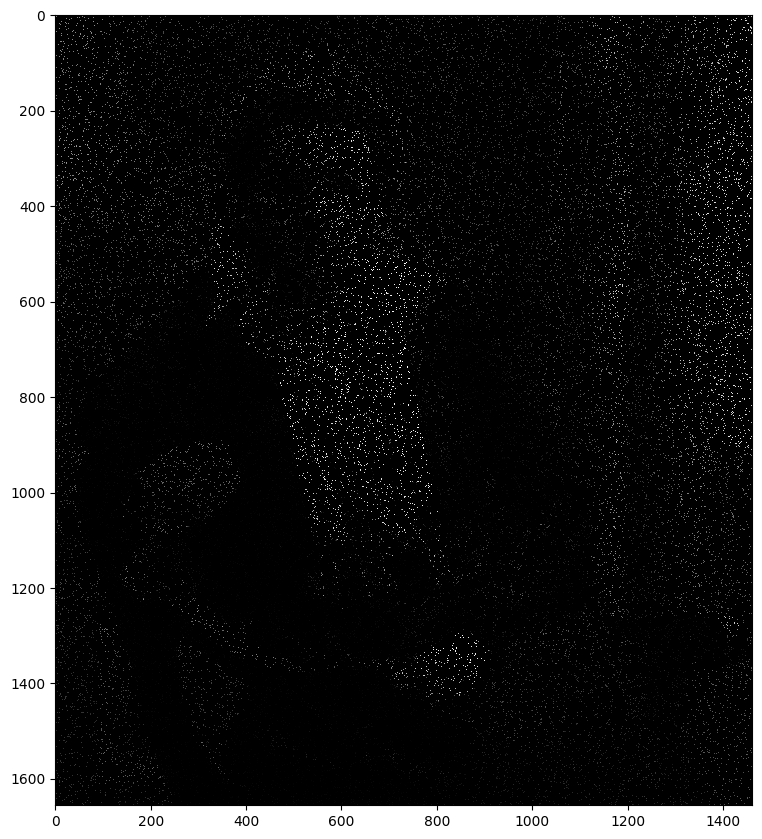

In [8]:
# set relative number of pixels
p = .05

# total number of pixels
m = int(p*n)
print("Total number of pixels: {}k".format(int(np.prod(Xorig.shape)/1000)))
print("Number of remaining pixels: {}k".format( int(m/1000) ))

# generate subsampled picture
mask = getRandMask(n, m)
Xsub = np.zeros(shape)
Xsub.flat[mask] = Xorig.flat[mask]
pltPic(Xsub)

### Choose parameters and run reconstruction

Relative error (support change): 0.975,  (1663950), 0.848 
Relative error (support change): 0.702,  (2444247), 0.519 (39102), 0.342 
Relative error (support change): 0.264,  (2304015), 0.214 
Relative error (support change): 0.180,  (2494814), 0.156 (2342), 0.142 
Relative error (support change): 0.139,  (2336862), 0.135 
Relative error (support change): 0.143,  (2494008), 0.130 (2448), 0.127 
Relative error (support change): 0.129,  (2289857), 0.128 
Relative error (support change): 0.136,  (2490949), 0.126 (3721), 0.125 
Relative error (support change): 0.126,  (2208214), 0.124 
Relative error (support change): 0.130,  (2484241), 0.123 (6591), 0.123 
Relative error (support change): 0.124,  (2047282), 0.121 
Relative error (support change): 0.125,  (2456250), 0.120 (19422), 0.120 
Relative error (support change): 0.121,  (2052573), 0.120 
Relative error (support change): 0.124,  (2456757), 0.120 (19362), 0.120 


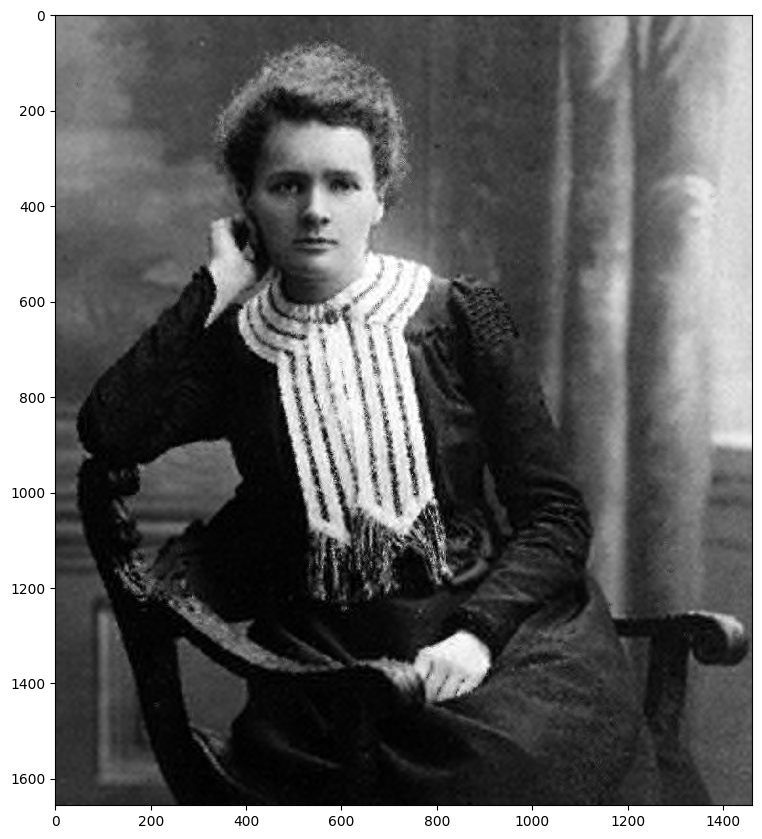

In [9]:
### schedule for DCT and WT iterations
steps_wt = 14
steps_dct = 10 #parameter for nr. of steps in fixed basis
N = 7 #nr. of switching bases: wt and dct

# threshold values
# th_dct = 3
# th_wt = 4
th_wt  = np.append( np.linspace(25,4,N-1), 4 )
th_dct = np.append( np.linspace(15,3,N-1), 3 )

# set initial guess for the reconstruction
if 'Xrec' not in locals():
    Xrec = Xsub
    
Xrec = Xsub

# set transformations
dct = DCT(shape)
wt = WT(shape, wavelet=wlet,level=L, amplify=amp)

#with myprofile.Profiler(fname='profile.dat'):
for j in range(N):
    thOp = softTO(th_dct[j])
    Xrec=FISTA(dct, thOp, mask, Xsub, stepsize = .75, n_steps=steps_dct, Xorig=Xorig, X0=Xrec)
    
    thOp = softTO(th_wt[j])
    Xrec=FISTA(wt, thOp, mask, Xsub, stepsize = .75, n_steps=steps_wt, Xorig=Xorig, X0=Xrec)

pltPic(Xrec)

### Compare to original picture

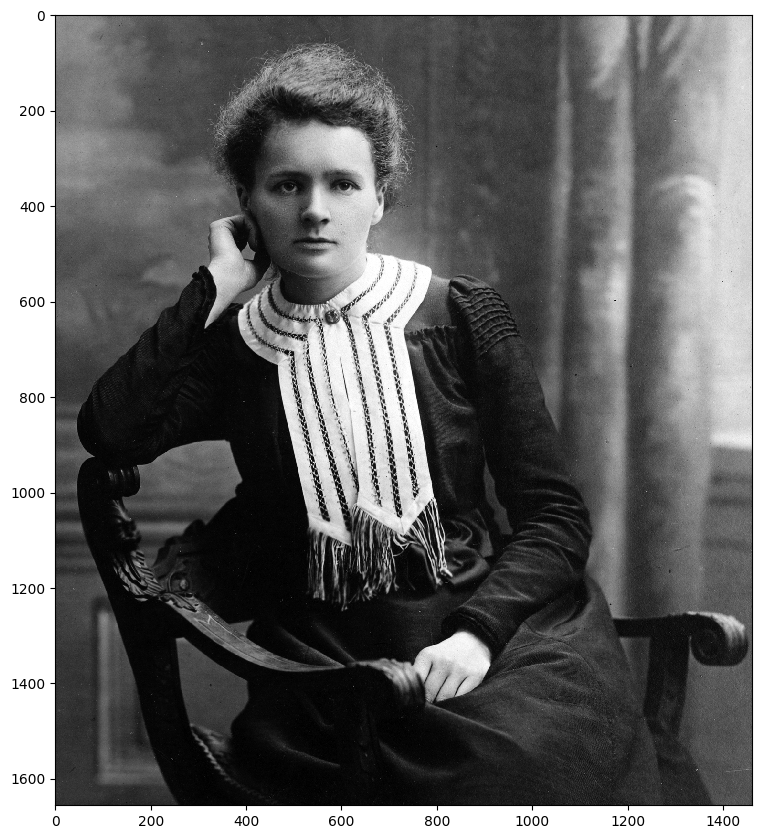

In [10]:
pltPic(Xorig)

## Export images

In [12]:
# make black pixels in the masked picture Xsub white
Xsub2 = Xsub.copy()
Xsub2[Xsub2==0.0] = Xsub2.max()

imageio.imwrite(r"E:\CS_image_recovery_demo\pics\marie_curie_masked.jpg", Xsub2.astype(np.uint8))
imageio.imwrite(r"E:\CS_image_recovery_demo\pics\marie_curie_rec.jpg", Xrec.astype(np.uint8))